<center> <h1> Detecting COVID-19 with Chest X Ray using PyTorch </h1></center>

The task is to classify chest X-Ray scan images into 3 classes: 
1. Normal
2. Viral Pneumonia
3. COVID-19

The dataset used here is the **COVID-19 Radiography Dataset** obtained from [Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database).

---

### Setting up environment from GitHub

In [ ]:
%cd '/content/'
# !rm -r covid-19-detection

In [28]:
!git clone "{GIT_PATH}"

Cloning into 'covid-19-detection'...
remote: Enumerating objects: 2910, done.
remote: Total 2910 (delta 0), reused 0 (delta 0), pack-reused 2910
Receiving objects: 100% (2910/2910), 1.14 GiB | 27.02 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Checking out files: 100% (2912/2912), done.


In [1]:
%cd '/content/covid-19-detection'

/content/covid-19-detection


### Importing Libraries

Let us import the required libraries...

In [2]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cu102


### Preparing Training and Test Sets

In [3]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

### Creating Custom Dataset

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal','viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        
        # Ensures that index is not out of bounds
        # Since classes have different number of images (class imbalance problem)
        index = index % len(self.images[class_name])
        index_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], index_name)
        image = Image.open(image_path).convert('RGB')
        
        # Return the transformed image and its class label
        return self.transform(image), self.class_names.index(class_name)
        
        

### Image Transformations

Let us create 2 transform objects -- one each for train and test set.

In [5]:
train_transform = torchvision.transforms.Compose([
    
    # ResNet-18 Model will be used which has weights pretrained on 'imagenet' dataset
    # This requires images to be resized.
    torchvision.transforms.Resize(size=(224,224)),
    
    # Data augmentation - Horizontal Flip
    torchvision.transforms.RandomHorizontalFlip(),
    
    # Convert image to tensor
    torchvision.transforms.ToTensor(),
    
    # Normalising the values
    # To take advantage of transfer learning, 
    # normalise in the same way that 'imagenet' was normalised
    # So specify the mean and standard deviation for 3 channels (RGB)
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])


Now, let us create the test transform object. The only difference is that data augmenation (Horizontal Flip) is not required for test data.

In [6]:
test_transform = torchvision.transforms.Compose([
    
    # ResNet-18 Model will be used which has weights pretrained on 'imagenet' dataset
    # This requires images to be resized.
    torchvision.transforms.Resize(size=(224,224)),
    
    # Convert image to tensor
    torchvision.transforms.ToTensor(),
    
    # Normalising the values
    # To take advantage of transfer learning, 
    # normalise in the same way that 'imagenet' was normalised
    # So specify the mean and standard deviation for 3 channels (RGB)
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])


### Prepare DataLoader

In [7]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [8]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [9]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of train batches =', len(dl_train))
print('Number of test batches =', len(dl_test))

Number of train batches = 470
Number of test batches = 15


### Data Visualisation

In [10]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        
        # Convert to from tensor to numpy
        # Take its transpose because
        # In ResNet implementation, the format for input is n_channels * n_height * n_width (!and not n_height * n_width * n_channels)
        image = image.numpy().transpose((1, 2, 0))  # Set axes
        
        # Images were normalised earlier.
        # To show the image denormalise the images
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        image = image*std + mean
        image = np.clip(image, 0.,1.)
        plt.imshow(image)
        
        colour = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colour)
        
    plt.tight_layout()
    plt.show()
        

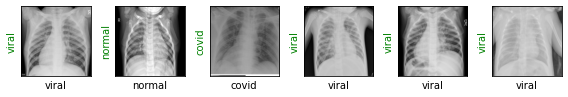

In [11]:
images, labels = next(iter(dl_train))

# Since predictions are not available for training data yet
# Labels are used in place of predictions
show_images(images, labels, labels)

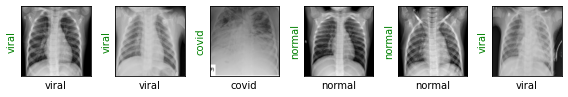

In [12]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

### Creating the Model

In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Modify the last (fully connected) layer by setting the number of `out_features` to 3 since we have 3 classes.

In [24]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [25]:
def show_preds():
    resnet18.eval()    # set to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _ , preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
    

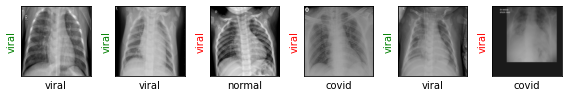

In [26]:
show_preds()

### Training the Model

In [29]:
def train(epochs):
    print('Started training...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()   # set to training mode
        
        for train_step, (images, labels) in enumerate(dl_train):
            
            # Refresh optimizer and set gradients to zero
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('\nEvaluating at step:', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _ , preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                    
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                print(f'Val loss = {val_loss:.4f}, Accuracy = {acc:.4f}')
                # show_preds()
                
                resnet18.train()
                
                if acc > 0.97:
                    print('\nPerformance condition satisifed, hence stopping...')
                    return
                
        train_loss /= (train_step+1)
        print(f'\nTraining loss = {train_loss:.4f}')
     

In [30]:
train(epochs=5)

Started training...
Starting epoch 1/5

Evaluating at step: 0
Val loss = 0.0577, Accuracy = 0.9778

Performance condition satisifed, hence stopping...


### Final Results

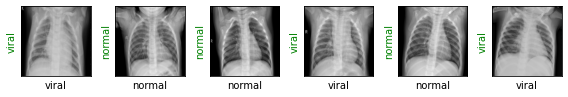

In [31]:
show_preds()

### Save as Python Script

In [33]:
!jupyter nbconvert 'Covid-19-detection.ipynb' --to python

[NbConvertApp] Converting notebook Covid-19-detection.ipynb to python
[NbConvertApp] Writing 9461 bytes to Covid-19-detection.py
